In [127]:
import numpy as np
import pandas as pd 
from shapely.wkt import loads
from shapely.geometry import Point
import geopandas as gpd
import sys
sys.path.insert(0, '/Users/bingyu')
from sp import interface
import matplotlib.pyplot as plt

In [251]:
class Train():
    def __init__(self):
        self.train_id = None ### use GTFS trip_id
        self.schedule = None ### concise dataframe of the (time, location)
        self.capacity = 100
        self.current_occupancy = None
        
    def add_schedule(self, schedule_df):
        
        ### add train_id
        self.train_id = schedule_df.iloc[0]['trip_id']
        
        ### add schedule
        schedule_df['arrival_time'] = schedule_df['arrival_time'].apply(
            lambda x: 3600*int(x.split(':')[0]) + 60*int(x.split(':')[1]) +
            int(x.split(':')[2]))
        schedule_df['departure_time'] = schedule_df['departure_time'].apply(
            lambda x: 3600*int(x.split(':')[0]) + 60*int(x.split(':')[1]) +
            int(x.split(':')[2])) + 30
        
        schedule_list = [(0, 'init')]
        for row in schedule_df.itertuples():
            schedule_list.append((getattr(row, 'arrival_time'), 'stop', 
                                  getattr(row, 'route_stop_id')))
            schedule_list.append((getattr(row, 'departure_time'), 'on_link',
                                  '{}-{}'.format(getattr(row, 'route_stop_id'), 
                                                 getattr(row, 'next_route_stop_id'))))
        self.schedule = pd.DataFrame(schedule_list, columns=['time', 'status', 'location'])
        self.schedule['next_time'] = self.schedule['time'].shift(-1)
        self.schedule = self.schedule[['time', 'next_time', 'status', 'location']]
        
    def update_location_occupancy(self, t):
        self.schedule['current_location'] = np.where(
            self.schedule['time']>t, 'future', np.where(
            self.schedule['next_time']>t, 'current', 'past'))

In [252]:
### process_schedule (gtfs)
### process individual trains
stop_times_table = pd.read_csv('google_transit_20211101_20220213_v2/stop_times.txt')
stop_times_table = stop_times_table[[
    'trip_id', 'arrival_time', 'departure_time', 'stop_id']]

### assign a route code to individual trains
trips_table = pd.read_csv('google_transit_20211101_20220213_v2/trips.txt')
stop_times_table = pd.merge(stop_times_table, trips_table[['trip_id', 'route_id']],
                           how='left', on='trip_id')
stop_times_table['route_stop_id'] = stop_times_table.apply(
    lambda x: '{}-{}'.format(x['route_id'], x['stop_id']), axis=1)

### assign locations to individual stations
stops_table = pd.read_csv('google_transit_20211101_20220213_v2/stops.txt')
stop_times_table = pd.merge(
    stop_times_table, 
    stops_table[['stop_id', 'stop_lon', 'stop_lat']], how='left', on='stop_id')
stop_times_table.head()

### make list of trains
list_of_trains = []
### make list of links
list_of_links = []

for trip_id, trip_schedule in stop_times_table.groupby('trip_id'):
    #print(trip_schedule)

    ### link to next stops
    #trip_schedule['next_stop_id'] = trip_schedule['stop_id'].shift(-1)
    trip_schedule['next_route_stop_id'] = trip_schedule['route_stop_id'].shift(-1)
    trip_schedule['next_stop_lon'] = trip_schedule['stop_lon'].shift(-1)
    trip_schedule['next_stop_lat'] = trip_schedule['stop_lat'].shift(-1)
    
    ### initiate trains
    train = Train()
    train.add_schedule(trip_schedule)
    list_of_trains.append(train)
    
    ### add network links
    list_of_links.append(trip_schedule[[
        'route_stop_id', 'next_route_stop_id', 
        'stop_lon', 'stop_lat', 'next_stop_lon', 'next_stop_lat']])
    break

In [253]:
### process network
all_links = pd.concat(list_of_links).drop_duplicates(
    subset=['route_stop_id', 'next_route_stop_id'])
all_links = all_links.loc[~pd.isnull(all_links['next_route_stop_id'])]
all_links['initial_weight'] = 1.0
all_links['geometry'] = all_links.apply(
    lambda x: 'LINESTRING({} {}, {} {})'.format(
        x['stop_lon'], x['stop_lat'], x['next_stop_lon'], x['next_stop_lat']
    ), axis=1)
all_links = gpd.GeoDataFrame(
    all_links, crs='epsg:4326', geometry=all_links['geometry'].map(loads))

### create nodes
all_nodes = pd.DataFrame(np.vstack(
    [all_links[['route_stop_id', 'stop_lon', 'stop_lat']].values,
     all_links[['next_route_stop_id', 'next_stop_lon', 'next_stop_lat']].values]),
    columns=['route_stop_id', 'stop_lon', 'stop_lat'])
all_nodes = all_nodes.drop_duplicates(subset=['route_stop_id'])
all_nodes['node_id'] = np.arange(all_nodes.shape[0])
all_nodes = gpd.GeoDataFrame(
    all_nodes, crs='epsg:4326', 
    geometry=[Point(xy) for xy in zip(all_nodes.stop_lon, all_nodes.stop_lat)])

station_nm_id_dict = {getattr(row, 'route_stop_id'): getattr(
    row, 'node_id') for row in all_nodes.itertuples()}
station_id_nm_dict = {getattr(row, 'node_id'): getattr(
    row, 'route_stop_id') for row in all_nodes.itertuples()}

### map stop names to node_ids
all_links['start_nid'] = all_links['route_stop_id'].map(station_nm_id_dict)
all_links['end_nid'] = all_links['next_route_stop_id'].map(station_nm_id_dict)
all_links = all_links[[
    'route_stop_id', 'next_route_stop_id', 'start_nid', 'end_nid',
    'initial_weight', 'geometry']]

display(all_nodes.head(3))
display(all_links.head(2))

### geometry dictionary
station_locations = {
    getattr(row, 'route_stop_id'): getattr(row, 'geometry') for row in all_nodes.itertuples()}
link_sections = {
    '{}-{}'.format(getattr(row, 'route_stop_id'), getattr(row, 'next_route_stop_id')):
    getattr(row, 'geometry').interpolate(0.2, 0.3) for row in all_links.itertuples()}

### create graph for shortest path calculations
network_g = interface.from_dataframe(all_links, 'start_nid', 'end_nid', 'initial_weight')

,route_stop_id,stop_lon,stop_lat,node_id,geometry
0,1-CONC,-122.029072,37.973757,0,POINT (-122.02907 37.97376)
1,1-PHIL,-122.055971,37.928434,1,POINT (-122.05597 37.92843)
2,1-WCRK,-122.067327,37.905791,2,POINT (-122.06733 37.90579)


,route_stop_id,next_route_stop_id,start_nid,end_nid,initial_weight,geometry
38967,1-CONC,1-PHIL,0,1,1.0,"LINESTRING (-122.02907 37.97376, -122.05597 37..."
38968,1-PHIL,1-WCRK,1,2,1.0,"LINESTRING (-122.05597 37.92843, -122.06733 37..."


In [271]:
### create od
num_travelers = 100
traveler_origins = np.random.choice(all_stations['node_id'], num_travelers)
traveler_destins = np.random.choice(all_stations['node_id'], num_travelers)
od_df = pd.DataFrame({
    'origin_nid': traveler_origins, 'destin_nid': traveler_destins})
od_df = od_df.loc[od_df['origin_nid']!=od_df['destin_nid']].copy()
od_df['traveler_id'] = np.arange(od_df.shape[0])
od_df['departure_time'] = np.random.randint(25980, 26980, od_df.shape[0])
od_df = od_df[od_df['destin_nid']>od_df['origin_nid']+1]
od_df.head(2)

,origin_nid,destin_nid,traveler_id,departure_time
0,3,13,0,26827
4,7,19,4,26538


In [272]:
### find paths
traveler_paths = dict()
traveler_key_stops = dict()
for traveler in od_df.itertuples():
    traveler_origin = getattr(traveler, 'origin_nid')
    traveler_destin = getattr(traveler, 'destin_nid')
    sp = network_g.dijkstra(traveler_origin, traveler_destin)
    sp_dist = sp.distance(traveler_destin)

    if sp_dist > 10e7:
        sp.clear()
        traveler_route = []
        key_stops = []
    else:
        sp_route = sp.route(traveler_destin)
        traveler_route = [
            station_id_nm_dict[start_nid] for (start_nid, end_nid) in sp_route] + [
            station_id_nm_dict[traveler_destin]]
        sp.clear()
        
        key_stops = []
        current_route = None
        for stop in traveler_route[:-2]:
            new_route = stop.split('-')[0]
            if new_route != current_route:
                key_stops.append(stop)
                current_route = new_route
        key_stops.append(traveler_route[-1])
        
    traveler_paths[getattr(traveler, 'traveler_id')] = traveler_route
    traveler_key_stops[getattr(traveler, 'traveler_id')] = {
        xy[0]:xy[1] for xy in zip(key_stops, key_stops[1:])}
    #break

In [292]:
### initialize traveler_df
traveler_df = od_df.copy()
traveler_df['traveler_status'] = 'platform'
traveler_df['association'] = traveler_df['origin_nid'].map(station_id_nm_dict)
traveler_df['next_station'] = traveler_df.apply(
    lambda x: traveler_key_stops[x['traveler_id']][x['association']], axis=1)
traveler_df.head()

,origin_nid,destin_nid,traveler_id,departure_time,traveler_status,association,next_station
0,3,13,0,26827,platform,1-LAFY,1-CIVC
4,7,19,4,26538,platform,1-19TH,1-COLM
5,5,11,5,26829,platform,1-ROCK,1-MONT
6,11,13,6,26417,platform,1-MONT,1-CIVC
10,12,16,10,26249,platform,1-POWL,1-GLEN


In [299]:
def find_next_station(traveler_key_stops, x):
    try:
        next_station = traveler_key_stops[x['traveler_id']][x['association']]
    except KeyError:
        next_station = None
    return next_station
    
def traveler_update(traveler_df, train_id, train_status, train_location, t):
    
    ### aboard
    aboard_travelers = (
        traveler_df['departure_time']<t) & (
        traveler_df['traveler_status']=='platform') & (
        traveler_df['association']==train_location)
    traveler_df['association'] = np.where(
        aboard_travelers, train_id, traveler_df['association'])
    traveler_df['traveler_status'] = np.where(
        aboard_travelers, 'train', traveler_df['traveler_status'])
    
    ### alight
    alight_travelers = (
        traveler_df['traveler_status']=='train') & (
        traveler_df['association']==train_id) & (
        traveler_df['next_station']==train_location)
    traveler_df['association'] = np.where(
        alight_travelers, train_location, traveler_df['association'])
    traveler_df['traveler_status'] = np.where(
        alight_travelers, 'platform', traveler_df['traveler_status'])
    ### all travelers
    traveler_df['next_station'] = traveler_df.apply(
        lambda x: find_next_station(traveler_key_stops, x) , axis=1)
    
    return traveler_df

In [312]:
train.schedule.head()

,time,next_time,status,location,current_location
0,0,25980.0,init,None,past
1,25980,26070.0,stop,1-CONC,past
2,26070,26340.0,on_link,1-CONC-1-PHIL,past
3,26340,26370.0,stop,1-PHIL,current
4,26370,26460.0,on_link,1-PHIL-1-WCRK,future


In [329]:
for t in [25981, 26080, 26350]:
    for train in list_of_trains:
        ### update train location
        train.update_location_occupancy(t)
        train_id = train.train_id
        train_status = train.schedule.loc[
            train.schedule['current_location']=='current', 'status'].iloc[0]
        train_location = train.schedule.loc[
            train.schedule['current_location']=='current', 'location'].iloc[0]
        print(train_id, train_status, train_location)
        
        ### update traveler_location
        if train_status == 'stop':
            traveler_df = traveler_update(traveler_df, train_id, train_status, train_location, t)
            #display(traveler_df)
#train.schedule.head()

938041 stop 1-CONC
938041 on_link 1-CONC-1-PHIL
938041 stop 1-PHIL


In [330]:
### get train position
train_locations=[]
for train in list_of_trains:
    train_current_row = train.schedule[train.schedule['current_location']=='current']
    train_current_row_locations = train_current_row['location'].iloc[0]
    train_current_row_status = train_current_row['status'].iloc[0]
    if train_current_row_status == 'stop':
        train_current_row_geometry = station_locations[train_current_row_locations]
    elif train_current_row_status == 'on_link':
        train_current_row_geometry = link_sections[train_current_row_locations]
    else:
        train_current_row_geometry = None
    train_locations.append([
        train_current_row_locations, train_current_row_geometry
    ])
train_locations_df = pd.DataFrame(train_locations, columns=['location', 'geometry'])
train_locations_df = gpd.GeoDataFrame(train_locations_df, crs='epsg:4326', geometry=train_locations_df['geometry'])

In [335]:
### get traveler locations
traveler_locations_df = traveler_df.groupby(
    ['traveler_status', 'association']).size().to_frame(
    name='num_travelers').reset_index(drop=False)
traveler_locations_df = pd.merge(
    traveler_locations_df, all_nodes[['route_stop_id', 'geometry']], 
    how='left', left_on='association', right_on='route_stop_id')
# traveler_locations_df = pd.merge(
#     traveler_locations_df, train_locations_df[['location', 'geometry']], 
#     how='left', left_on='association', right_on='location')
traveler_locations_df

,traveler_status,association,num_travelers,route_stop_id,geometry
0,platform,1-12TH,2,1-12TH,POINT (-122.27163 37.80348)
1,platform,1-16TH,2,1-16TH,POINT (-122.41970 37.76517)
2,platform,1-19TH,2,1-19TH,POINT (-122.26876 37.80808)
3,platform,1-BALB,1,1-BALB,POINT (-122.44746 37.72175)
4,platform,1-CIVC,1,1-CIVC,POINT (-122.41383 37.77941)
5,platform,1-CONC,6,1-CONC,POINT (-122.02907 37.97376)
6,platform,1-EMBR,1,1-EMBR,POINT (-122.39704 37.79276)
7,platform,1-LAFY,8,1-LAFY,POINT (-122.12462 37.89318)
8,platform,1-MCAR,5,1-MCAR,POINT (-122.26711 37.82880)
9,platform,1-MONT,2,1-MONT,POINT (-122.40159 37.78917)


<AxesSubplot:>

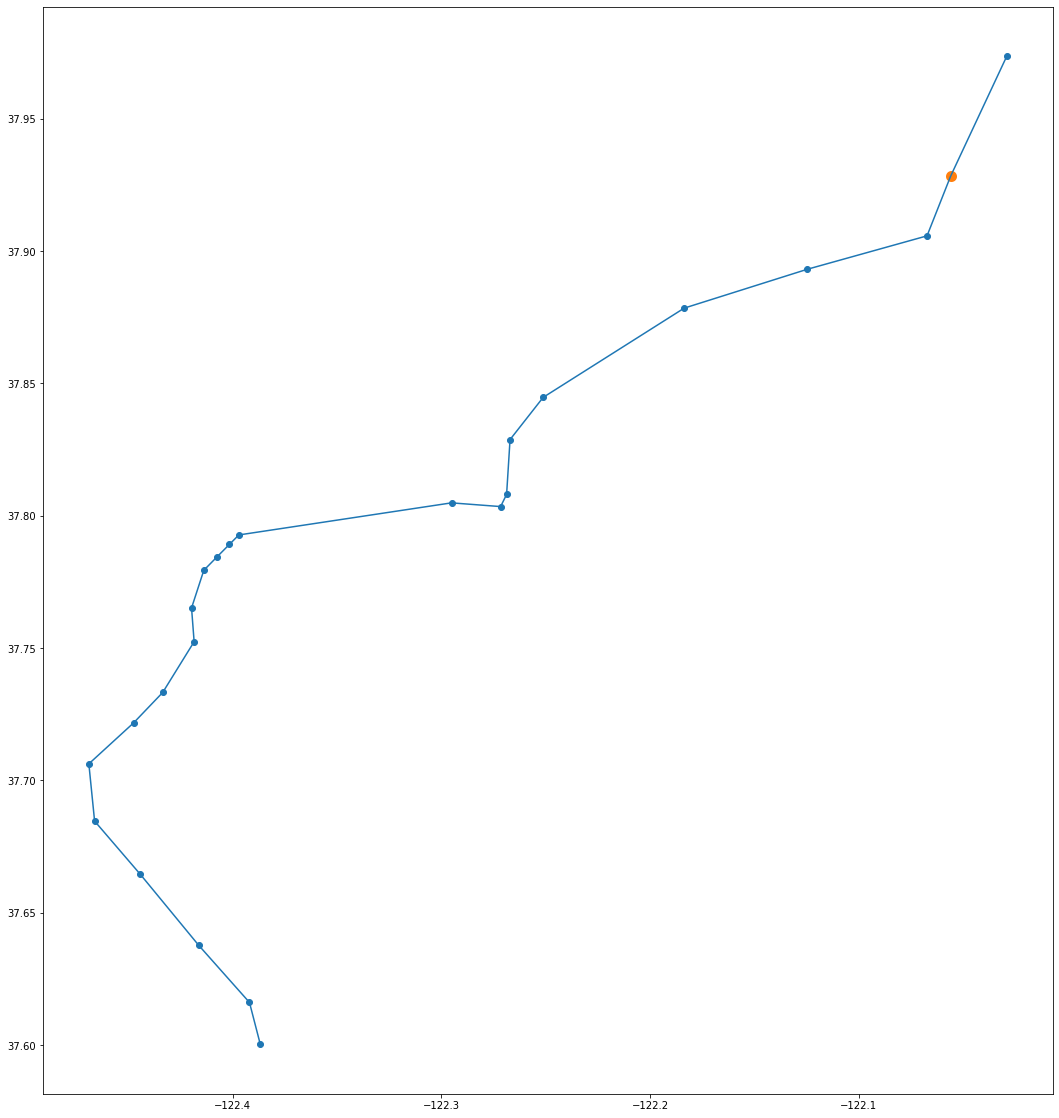

In [332]:
fig, ax = plt.subplots(figsize=(20, 20))
all_links.plot(ax=ax)
all_nodes.plot(ax=ax)
train_locations_df.plot(ax=ax, lw=5)
#traveler_locations_df.plot(ax=ax, lw=traveler_locations_df['num_travelers'], c='red')